# Predicting the passage of bills with text analysis

Congress has recently become famous for a lot of things, but the functions of their jobs remain pretty simple. They argue a lot and make decisions to either pass resolutions or bills, or to not. 

Given that roughly 95% of all bills fail to pass, I decided I would like to see if we can predict if a bill will or won't pass based on the summaries of the bills alone.

##### Few quick points:
* There's been a bit of academic research done on this topic already, mostly using bill text itself or bill titles.
* The bill summaries are prepared by the Congressional Research Service (CRS) and are relatively straightforward in the way that they describe bills.
* I classify things in a binary--either they passed or they didn't. This makes for some REALLY unbalanced classes. I'd initially tried to classify them into bills that didn't get a hearing or didn't make it past committee, bills that were at least heard on the floor, and ones that passed. That became extremely complicated because the CRS hates people and happiness. 
* I classify 'public laws' as enacted bills and acts per the [CRS codebook.](https://www.gpo.gov/fdsys/bulkdata/BILLSUM/resources/BILLSUM-XML_User-Guide-v2.pdf) 
* I ran about 15,000 models and my goal was for the models to be slightly better than random guessing. Random guessing, just so ou know, is about 90%. Unbalanced classes = the best.
* I also did a tonne of messing around with different ways of looking at and analyzing text, so that should be good fun. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import os
import xml.etree.ElementTree as ET 
plt.style.use('ggplot')
% matplotlib inline

In [ ]:
#this sets is so you can see everything in the columns. This is a great tool for pre-processing and a terrible tool otherwise.
pd.set_option('display.max_colwidth', -1)

### Getting the data

So here's a quick caveat about data quality when you're trying to get information from Congress. Congress only started providing bulk data in 2014, with everything prior to that coming from the fantastic [govtrack folk](https://www.govtrack.us/). I decided to work with a small chunk of the data initially so decided to only use the summaries for the 113<sup>th</sup> and the 114<sup>th</sup> Congresses (Congressi? Congreese?). 

Then came the messy bit.

In [ ]:
#here's a quick snapshot of my XML code. I ran this over every single individual set of bills to build a larger dataset for each Congress.
df_114 = pd.DataFrame()

path = '../../../../../Downloads/BILLSUM-114-hr'
for filename in os.listdir(path):
    if not filename.endswith('.xml'): continue
    fullname = os.path.join(path, filename)
    tree = ET.parse(fullname) #Initiates the tree Ex: <user-agents>
    root = tree.getroot() #Starts the root of the tree Ex: <user-agent>
    for item in root.findall('item'):
        origin = item.get('originChamber')
        measure_id = item.get('measure-id')
        congress = item.get('congress')
        measure_type = item.get('measure-type')
        update_date = item.get('update-date')
        publish_date = item.get('orig-publish-date')
    summary = root.find('.//summary-text').text.strip()
    summary = re.sub('<[^<]+?>', '', summary)
    action = root.find('.//action-desc').text
    title = root.find('.//title').text
    action_date = root.find('.//action-date').text
    df_114 = df_114.append({'measure_id': measure_id, 'congress':congress, 'origin':origin, 'measure_type':measure_type, 'action_date':action_date, 'publish_date':publish_date, 'title':title, 'action':action,'summary': summary}, ignore_index=True)


In [ ]:
#I created a target variable where 1 is a passed bill or resolution and 0 is a bill or resolution that failed
df_114['target'] = [1 if 'Passed' in x else 1 if 'Public Law' in x else 0 for x in df_114.action]

Here's more of my data quality caveat. Turns out, CRS doesn't track specific bills with any clear ID, it just assumes that what you want is for each action on a bill to be treated as a separate event, completely unconnected to the original bill. So I had to clean up all duplicates.

In [ ]:
#I first dropped duplicates if they had the same title AND target
df_114.drop_duplicates(['title', 'target'], keep='last', inplace=True)

In [ ]:
#I then dropped duplicates if the summary and target were the same
df_114.drop_duplicates(['summary', 'target'], keep='last', inplace=True)

In [ ]:
#And then I dropped duplicates if there were two versions of the same thing--one when the bill was introduced, and one when it passed
df_114.sort_values('target').drop_duplicates(['title'], keep='last')

In [ ]:
#then i saved the dataframe
df_114.to_csv('clean114', index=False)

### I guess we could do some EDA

But only because I have a burning question: what time of the year seems to work best for your bills actually being passed?

In [15]:
#first change the action_date category to one we can work with 
df.action_date = pd.to_datetime(df.action_date)

In [16]:
#and then pull out the week
df['week'] = df.action_date.dt.week

In [17]:
#the month
df['month'] = df.action_date.dt.month

In [18]:
#and the year
df['year'] = df.action_date.dt.year

In [19]:
#that makes sense. Congress DID basically go on holiday in 2016.
df.year.value_counts()

2013    4014
2015    4012
2014    2673
2016    2144
Name: year, dtype: int64

In [21]:
#but apparently more laws got passed in 2016! 
df.groupby('year').target.value_counts()

year  target
2013  0         3848
      1          166
2014  0         2386
      1          287
2015  0         3798
      1          214
2016  0         1858
      1          286
Name: target, dtype: int64

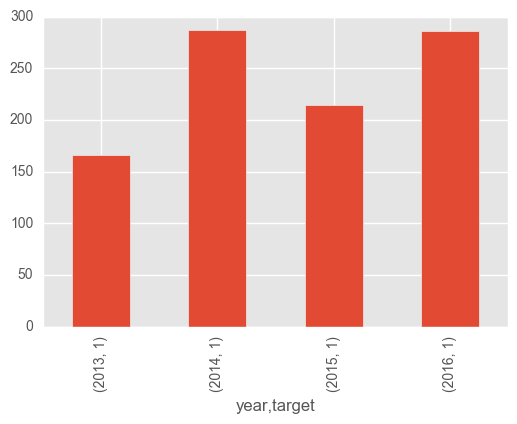

In [22]:
#which year was most effective I hear you ask?
df[df.target == 1].groupby('year').target.value_counts().plot(kind='bar')
#2013 was just bad. Let's move on.

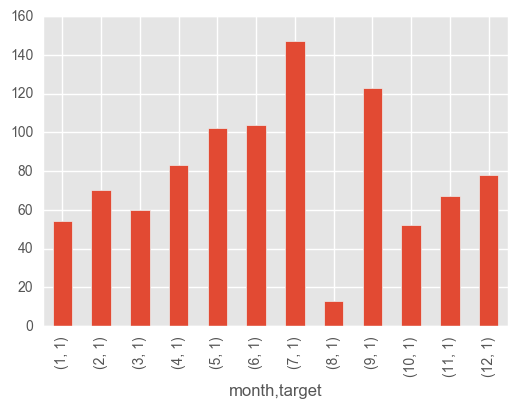

In [24]:
#which month should YOU choose to put your bill in?
df[df.target == 1].groupby('month').target.value_counts().plot(kind='line')
#so a flurry of activity just before and after the August recess. Cool

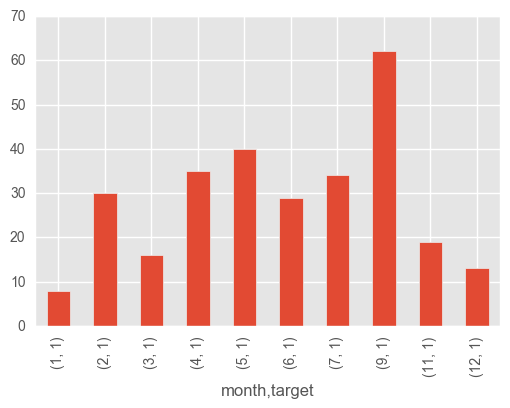

In [177]:
#and by year?
df[(df.target == 1) & (df.year == 2016)].groupby('month').target.value_counts().plot(kind='bar')


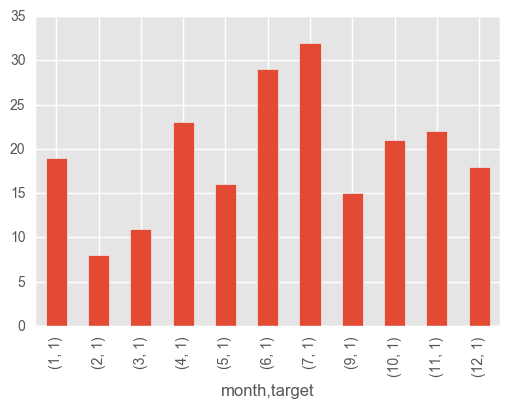

In [178]:
df[(df.target == 1) & (df.year == 2015)].groupby('month').target.value_counts().plot(kind='bar')


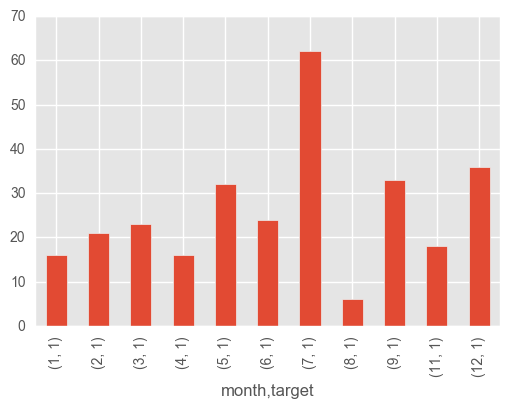

In [179]:
df[(df.target == 1) & (df.year == 2014)].groupby('month').target.value_counts().plot(kind='bar')


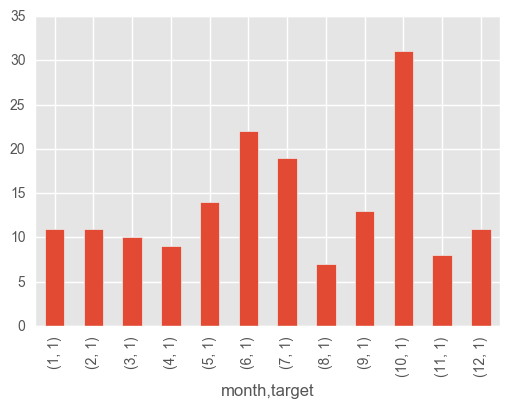

In [180]:
df[(df.target == 1) & (df.year == 2013)].groupby('month').target.value_counts().plot(kind='bar')


### Science-ing some data

In [4]:
#read in both dataframes, one for the 113th, one for the 114th
df = pd.read_csv('clean113')
df_114 = pd.read_csv('clean114')

In [5]:
#and merge them so we can look at both of them
df = pd.concat([df, df_114])

In [7]:
#we have a total of 12843 bills
df.shape

(12843, 10)

In [182]:
df.head()

,action,action_date,congress,measure_id,measure_type,origin,publish_date,summary,title,target,week,month,year
0,Introduced in House,2014-12-10,113,id113hr1,hr,HOUSE,2014-12-10,Tax Reform Act of 2014 - Title I: Tax Reform f...,Tax Reform Act of 2014,0,50,12,2014
1,Introduced in House,2014-06-30,113,id113hr5015,hr,HOUSE,2014-06-30,Help Employ and Recruit Our Excellent Servicem...,HEROES Grant Act of 2014,0,27,6,2014
2,Introduced in House,2014-06-30,113,id113hr5014,hr,HOUSE,2014-06-30,Illegal Entry Accountability Act of 2014 - Dir...,Illegal Entry Accountability Act of 2014,0,27,6,2014
3,Reported to House without amendment,2014-06-27,113,id113hr5013,hr,HOUSE,2014-06-27,(This measure has not been amended since it wa...,"Department of State, Foreign Operations, and R...",0,26,6,2014
4,Introduced in House,2014-06-26,113,id113hr5012,hr,HOUSE,2014-06-26,Summer Meals Act of 2014 - Amends the Richard ...,Summer Meals Act of 2014,0,26,6,2014


In [8]:
#this wouldn't be a necessary step if I'd remembered to create this category when I had made the 113 dataset. Oops.
df['target'] = [1 if 'Passed' in x else 0 for x in df.action]

In [9]:
print df['target'].value_counts()
print 11890.0/(11890 + 953)
#our baseline accuracy is 92%. That's going to be pretty hard to beat.

0    11890
1      953
Name: target, dtype: int64
0.925796153547


In [10]:
#let's set our y 
y = df['target']

<img src=https://cdn.meme.am/cache/instances/folder666/65701666.jpg>


I will use this image forever. 

In [72]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [92]:
#first TFIDF this
tfv = TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(1,2), max_features=10000)
X_all = tfv.fit_transform(df['summary'])

In [83]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=2, max_features=10000)
X_cv = cv.fit_transform(df['summary'])

In [73]:
#initialize a tonne of models
svc = SVC(kernel='linear', C=40)
lr = LogisticRegression()
rf = RandomForestClassifier()
xgbc = xgb.XGBClassifier()

In [59]:
#add some names to make things look nice
names = ["passed", "introduced", "predicted passed", 'predicted introduced']

#### Notes:

We're chiefly looking assessing the models based on:
1. Accuracy score
2. F-1 score 
3. The area under the Received Operating Characteristic curve (the closer the area is to 1, the better your model is doing)


            predicted passed  predicted introduced
passed                    52                   139
introduced                21                  2357
accuracy score is 0.937718956793
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2378
          1       0.71      0.27      0.39       191

avg / total       0.93      0.94      0.92      2569



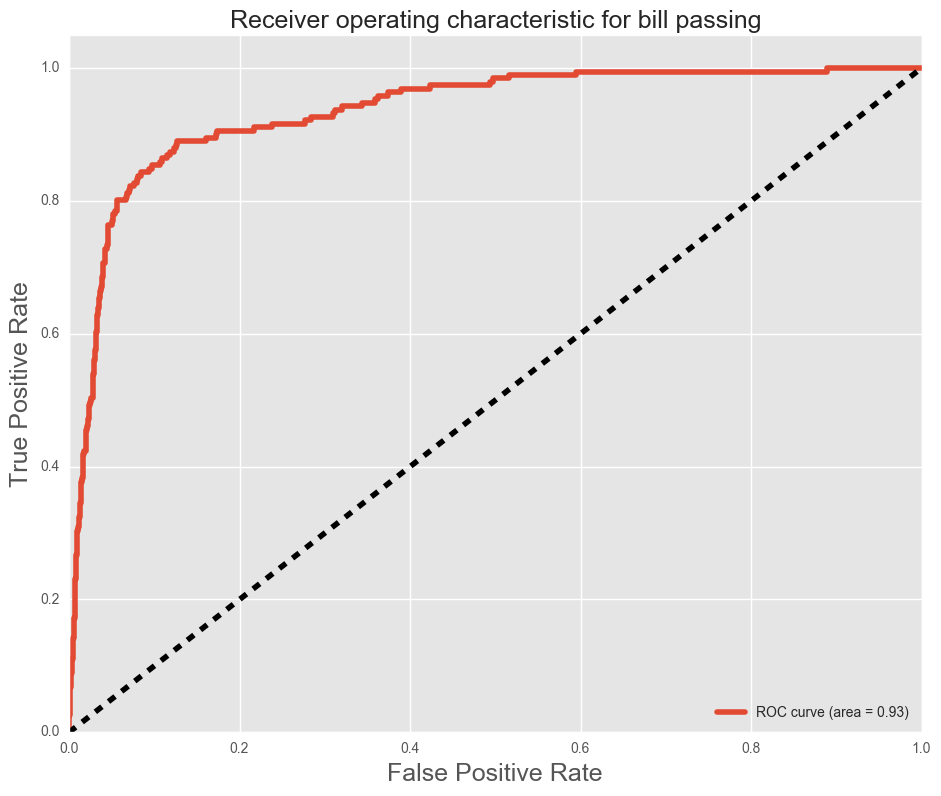

In [93]:
def do_model(evaluator, X, y, names):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
    model = evaluator.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=[names[0:2]], columns=[names[2:]])
    print confusion
    acc = accuracy_score(Y_test, Y_pred)
    print "accuracy score is", acc
    print(classification_report(Y_test, Y_pred))
    
    try:
        Y_score = model.decision_function(X_test)
    except:
        Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
        Y_score = Y_pp.class_1_pp

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

# For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for bill passing', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()    

do_model(lr, X_all, y, names)
#logistic regression is a percentage point better than random guessing. Cool!

            predicted passed  predicted introduced
passed                   102                    89
introduced                77                  2301
accuracy score is 0.935383417672
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      2378
          1       0.57      0.53      0.55       191

avg / total       0.93      0.94      0.93      2569



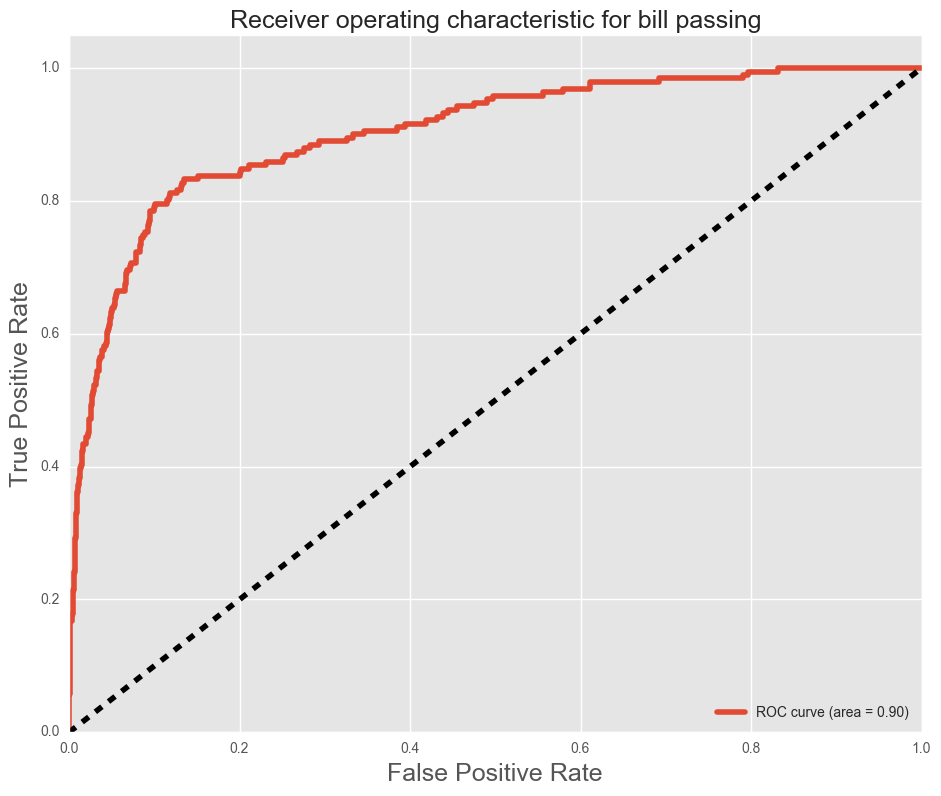

In [94]:
do_model(svc, X_all, y, names)
#that's a pretty decent rate for the SVC! 

            predicted passed  predicted introduced
passed                   128                    63
introduced                48                  2330
accuracy score is 0.956792526275
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2378
          1       0.73      0.67      0.70       191

avg / total       0.96      0.96      0.96      2569



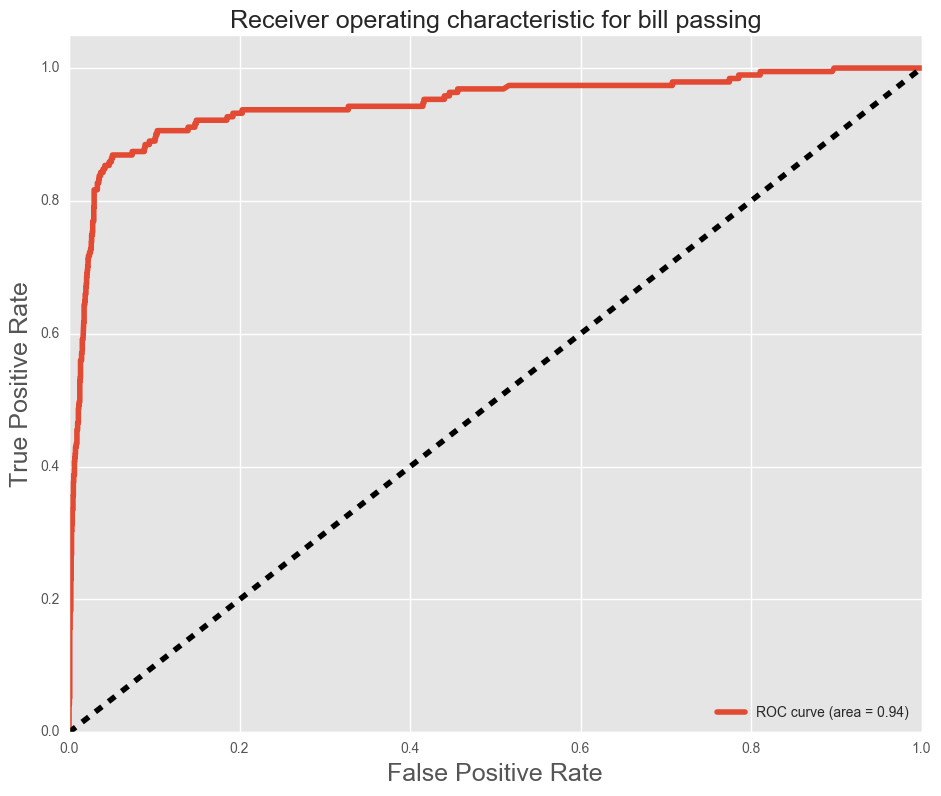

In [95]:
do_model(xgbc, X_all, y, names)
#and there's the free lunch.
#this is a joke. XGBoost is not a free lunch, and I'm kind of annoyed it beat out SVC.

            predicted passed  predicted introduced
passed                    99                    92
introduced                46                  2332
accuracy score is 0.946282600234
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      2378
          1       0.68      0.52      0.59       191

avg / total       0.94      0.95      0.94      2569



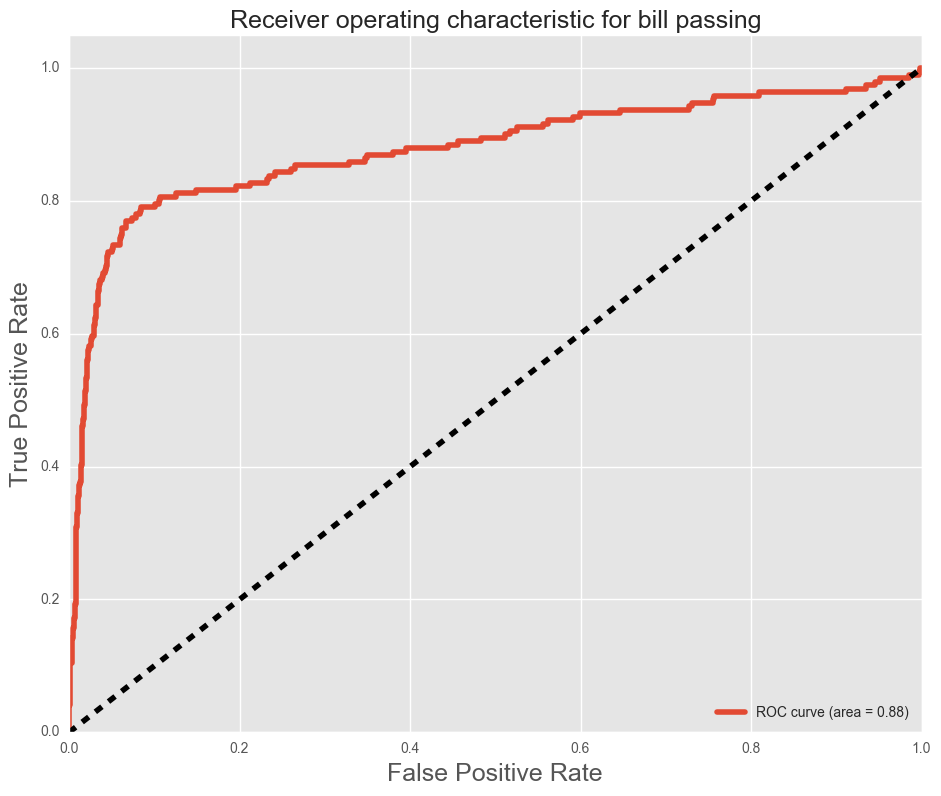

In [84]:
#does count vectorized data do better?
do_model(lr, X_cv, y, names)
#logreg DEFINITELY got more predictive!

            predicted passed  predicted introduced
passed                   105                    86
introduced                86                  2292
accuracy score is 0.933047878552
             precision    recall  f1-score   support

          0       0.96      0.96      0.96      2378
          1       0.55      0.55      0.55       191

avg / total       0.93      0.93      0.93      2569



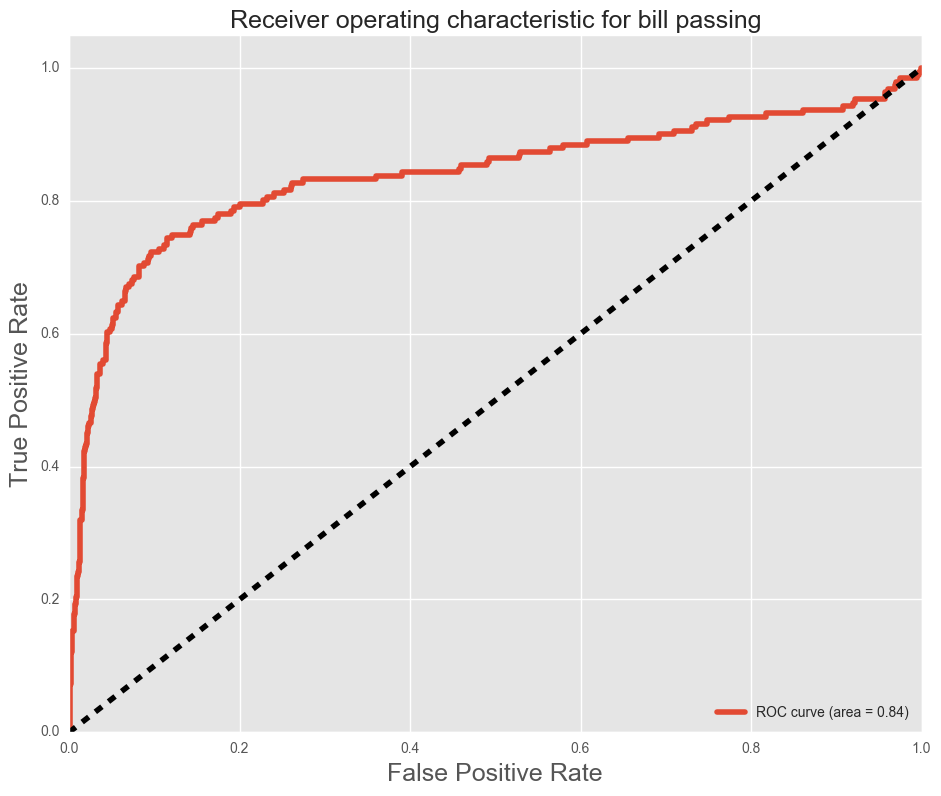

In [85]:
do_model(svc, X_cv, y, names)
#svc did not

            predicted passed  predicted introduced
passed                   127                    64
introduced                42                  2336
accuracy score is 0.958738808875
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2378
          1       0.75      0.66      0.71       191

avg / total       0.96      0.96      0.96      2569



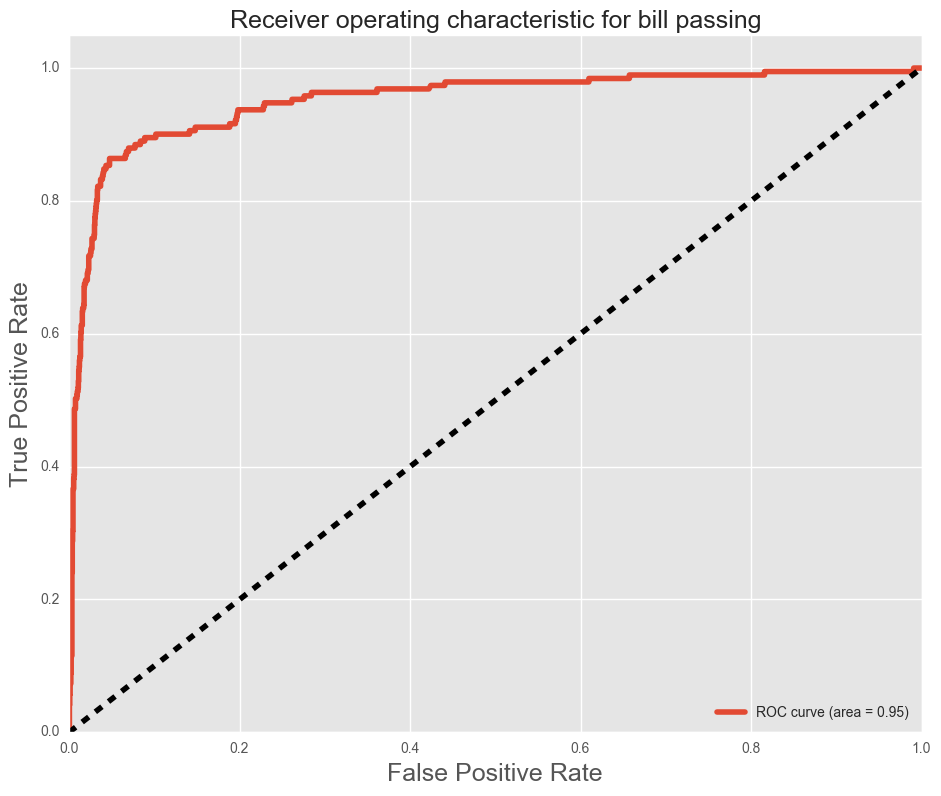

In [87]:
do_model(xgbc, X_cv, y, names)
#that's a better score on the XGB too!

## So the baseline model works. What happens when we expand it?



In [96]:
import nltk
import textblob

In [97]:
#First thing we're going to do is turn our words into lemmas. 
def split_into_lemmas(text):
    text = unicode(text, 'utf-8').lower()
    words = textblob.TextBlob(text).words
    return [word.lemmatize() for word in words]

In [98]:
tfv = TfidfVectorizer(analyzer=split_into_lemmas, min_df=2, max_df=0.7, ngram_range=(1,2), max_features=10000)
X_all = tfv.fit_transform(df['summary'])

In [ ]:
cv = CountVectorizer(analyzer=split_into_lemmas, min_df=2, max_df=0.7, ngram_range=(1,2), max_features=10000)
X_all = tfv.fit_transform(df['summary'])

In [99]:
#throw in title for fun
X_title = tfv.fit_transform(df['title'])

In [100]:
import scipy.sparse as sp

In [101]:
#join up the title and summary
h = sp.hstack((X_all, X_title), format='csr')

In [103]:
#make dummies out of the measure type columns
dummies = pd.get_dummies(df.measure_type, drop_first=True)

In [104]:
#join THOSE up too
extra = sp.csr_matrix(dummies).astype(float)
X_extra = sp.hstack((h, extra), format='csr')

            predicted passed  predicted introduced
passed                    56                   135
introduced                26                  2352
accuracy score is 0.937329700272
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2378
          1       0.68      0.29      0.41       191

avg / total       0.93      0.94      0.93      2569



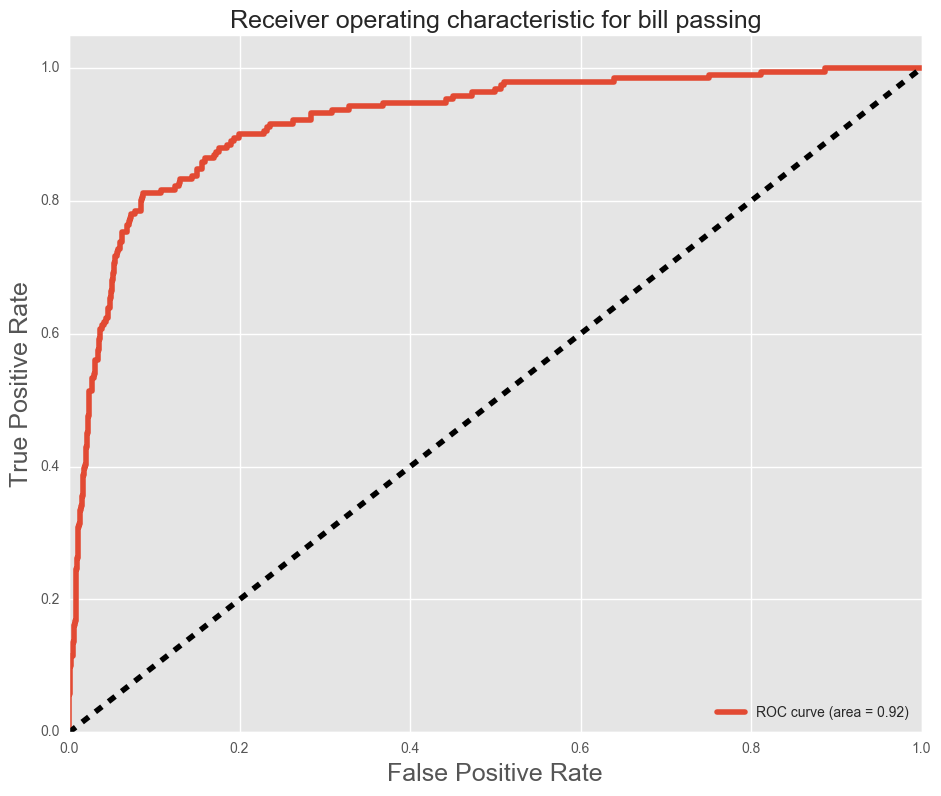

In [105]:
do_model(lr, X_extra, y, names)

            predicted passed  predicted introduced
passed                    95                    96
introduced                76                  2302
accuracy score is 0.933047878552
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      2378
          1       0.56      0.50      0.52       191

avg / total       0.93      0.93      0.93      2569



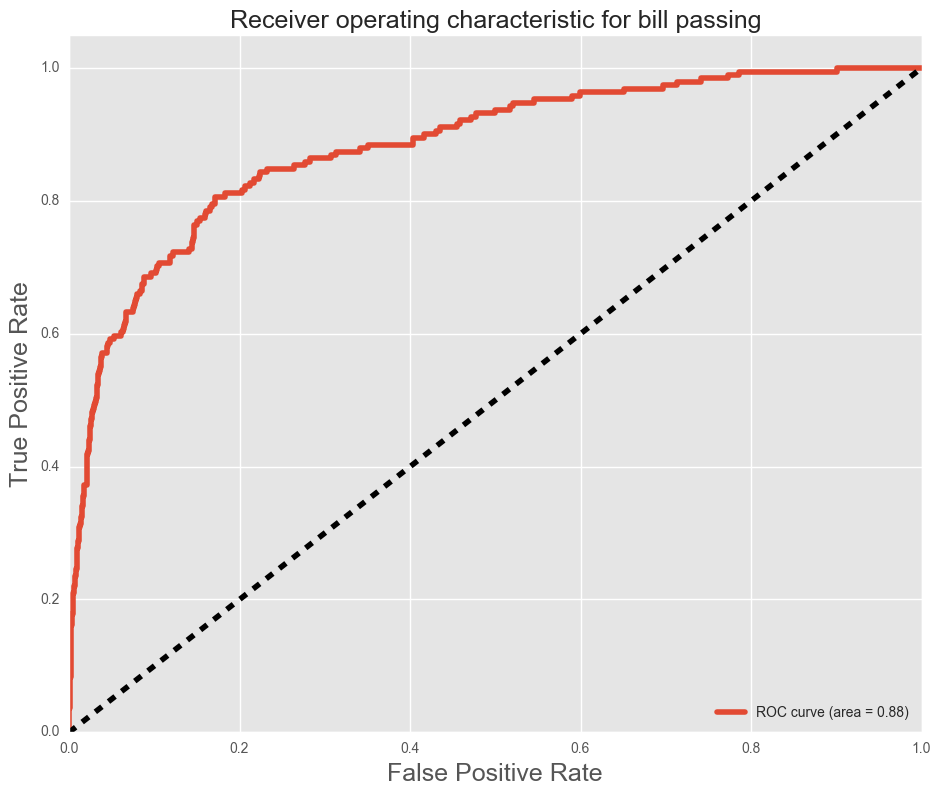

In [106]:
do_model(svc, X_extra, y, names)

            predicted passed  predicted introduced
passed                   121                    70
introduced                43                  2335
accuracy score is 0.956014013235
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2378
          1       0.74      0.63      0.68       191

avg / total       0.95      0.96      0.95      2569



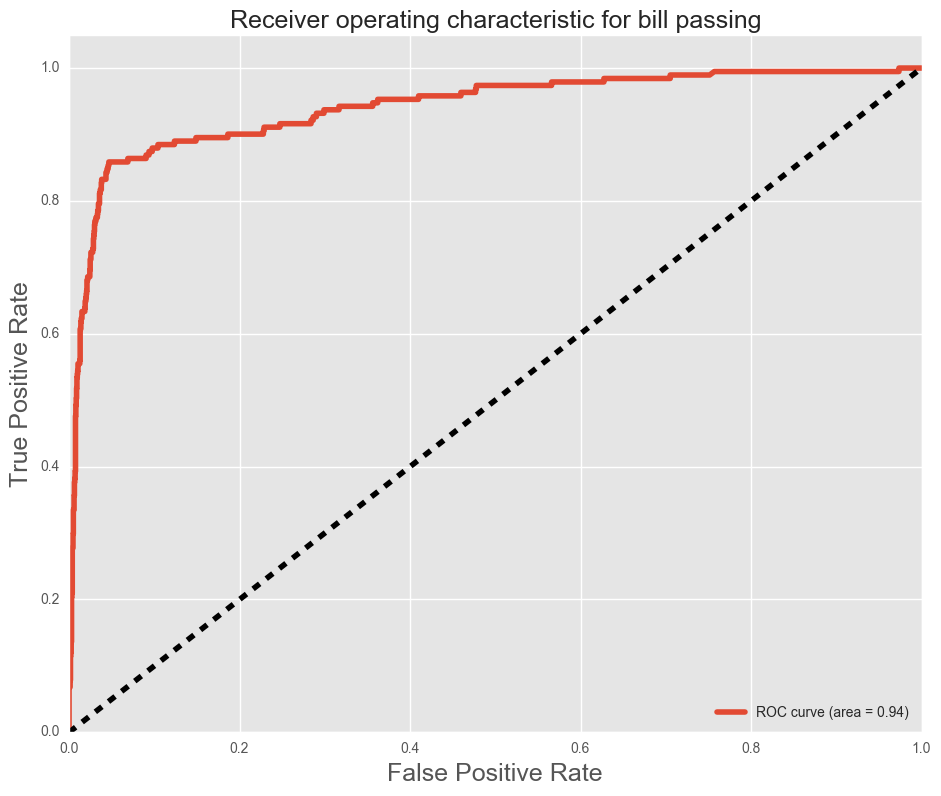

In [108]:
do_model(xgbc, X_extra, y, names)

            predicted passed  predicted introduced
passed                    56                   135
introduced                25                  2353
accuracy score is 0.937718956793
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2378
          1       0.69      0.29      0.41       191

avg / total       0.93      0.94      0.93      2569



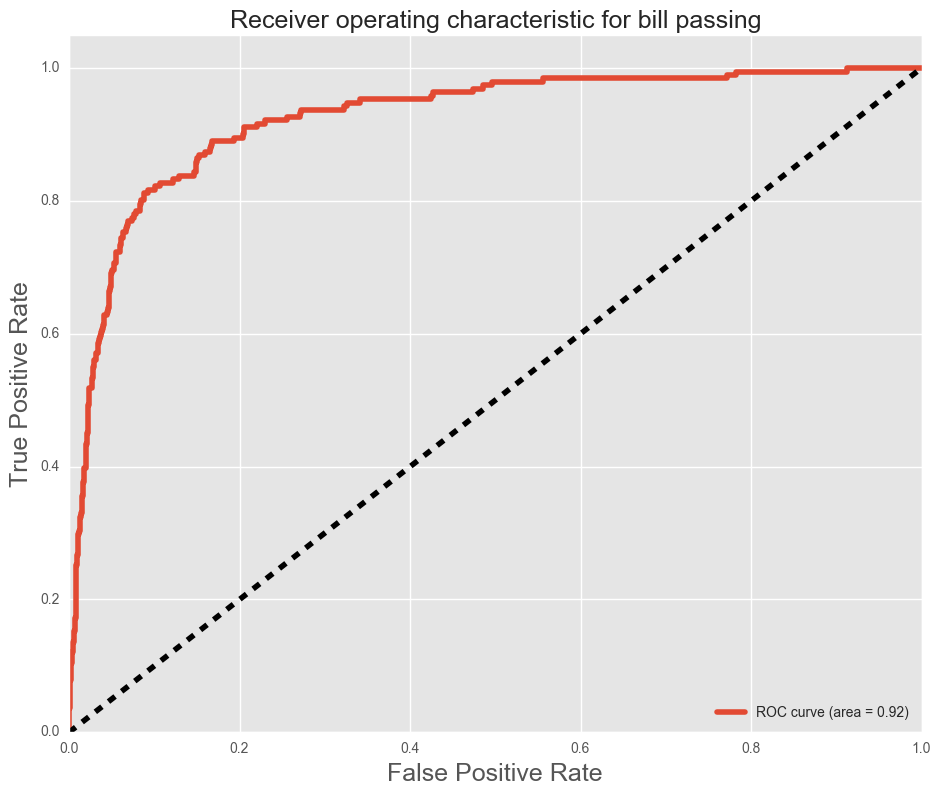

In [109]:
#and how do the three do without throwing in the dummies
do_model(lr, h, y, names)

            predicted passed  predicted introduced
passed                    97                    94
introduced                74                  2304
accuracy score is 0.934604904632
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      2378
          1       0.57      0.51      0.54       191

avg / total       0.93      0.93      0.93      2569



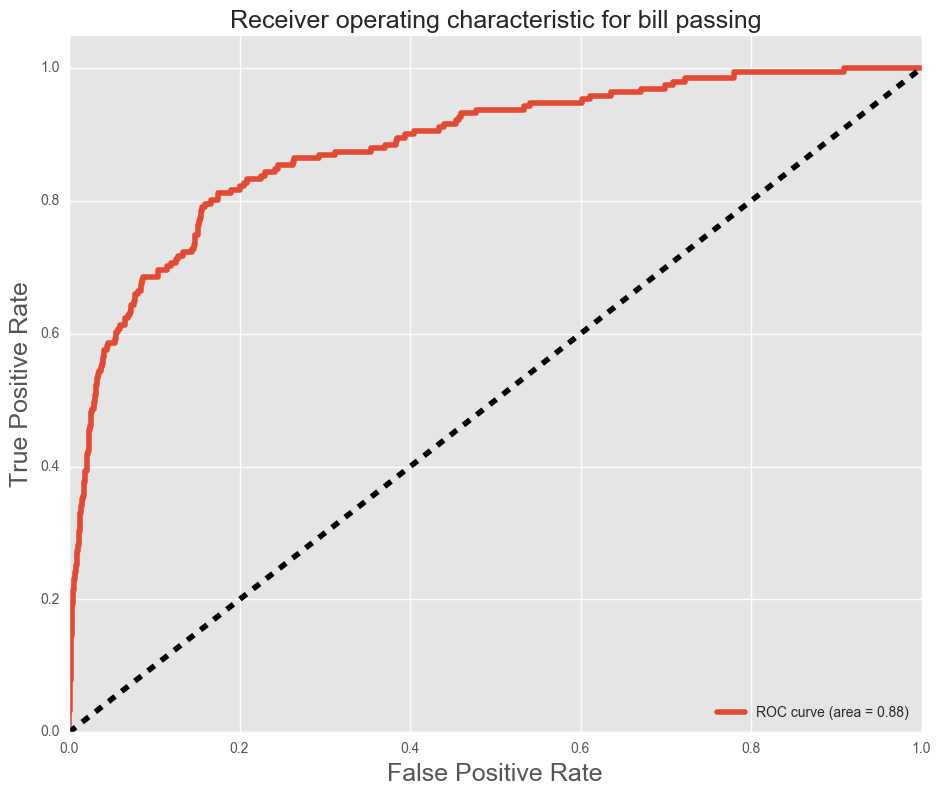

In [110]:
do_model(svc, h, y, names)

            predicted passed  predicted introduced
passed                   127                    64
introduced                46                  2332
accuracy score is 0.957181782795
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2378
          1       0.73      0.66      0.70       191

avg / total       0.96      0.96      0.96      2569



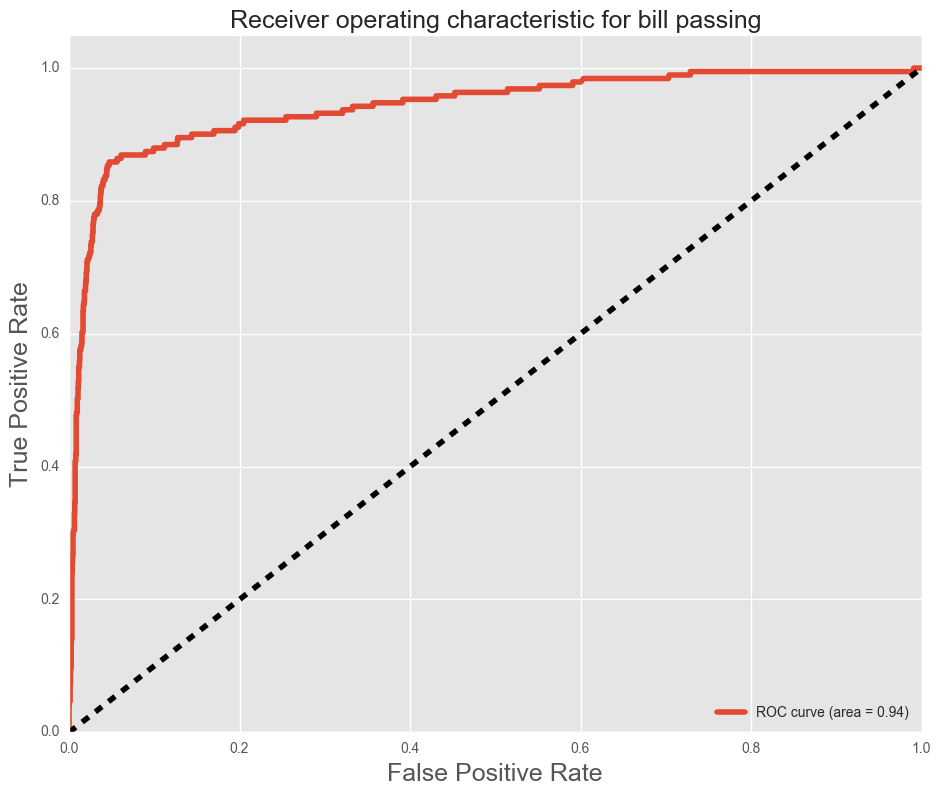

In [112]:
do_model(xgbc, h, y, names)

            predicted passed  predicted introduced
passed                    49                   142
introduced                28                  2350
accuracy score is 0.933826391592
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2378
          1       0.64      0.26      0.37       191

avg / total       0.92      0.93      0.92      2569



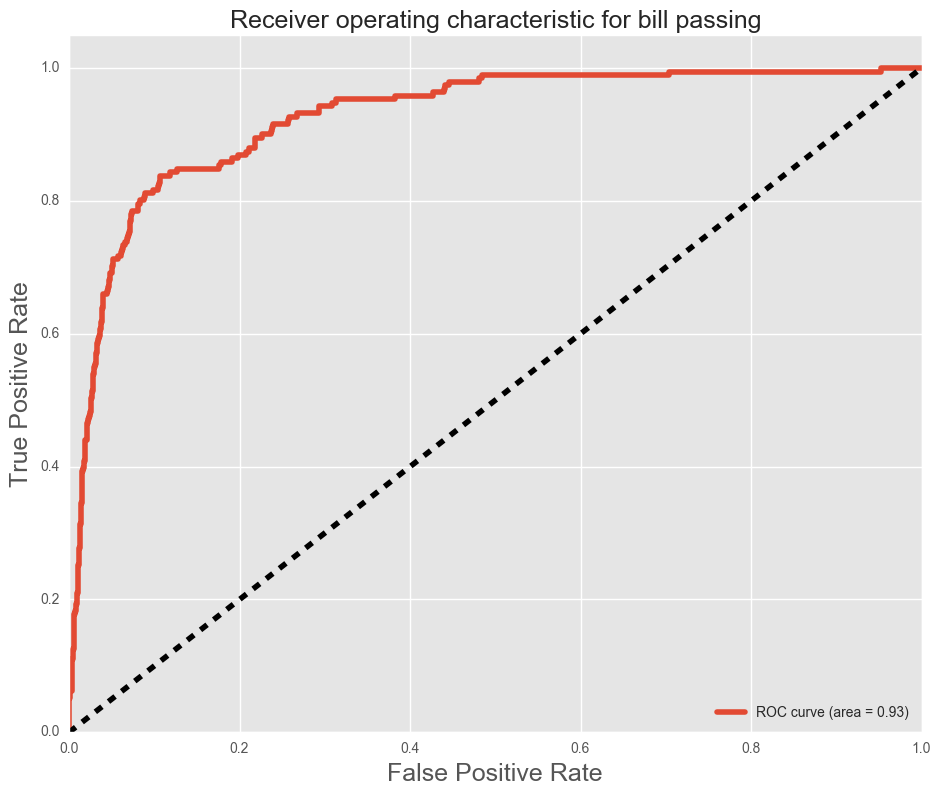

In [113]:
#and how about just with the lemmas
do_model(lr, X_all, y, names)

            predicted passed  predicted introduced
passed                   102                    89
introduced                85                  2293
accuracy score is 0.932269365512
             precision    recall  f1-score   support

          0       0.96      0.96      0.96      2378
          1       0.55      0.53      0.54       191

avg / total       0.93      0.93      0.93      2569



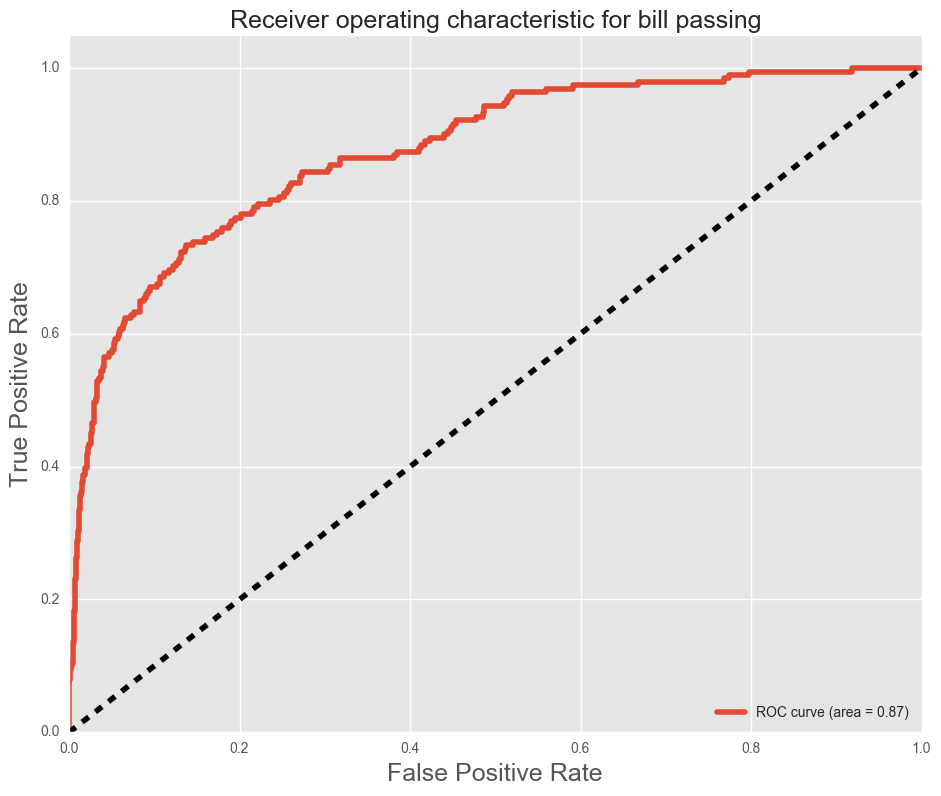

In [114]:
do_model(svc, X_all, y, names)

            predicted passed  predicted introduced
passed                   122                    69
introduced                41                  2337
accuracy score is 0.957181782795
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2378
          1       0.75      0.64      0.69       191

avg / total       0.95      0.96      0.96      2569



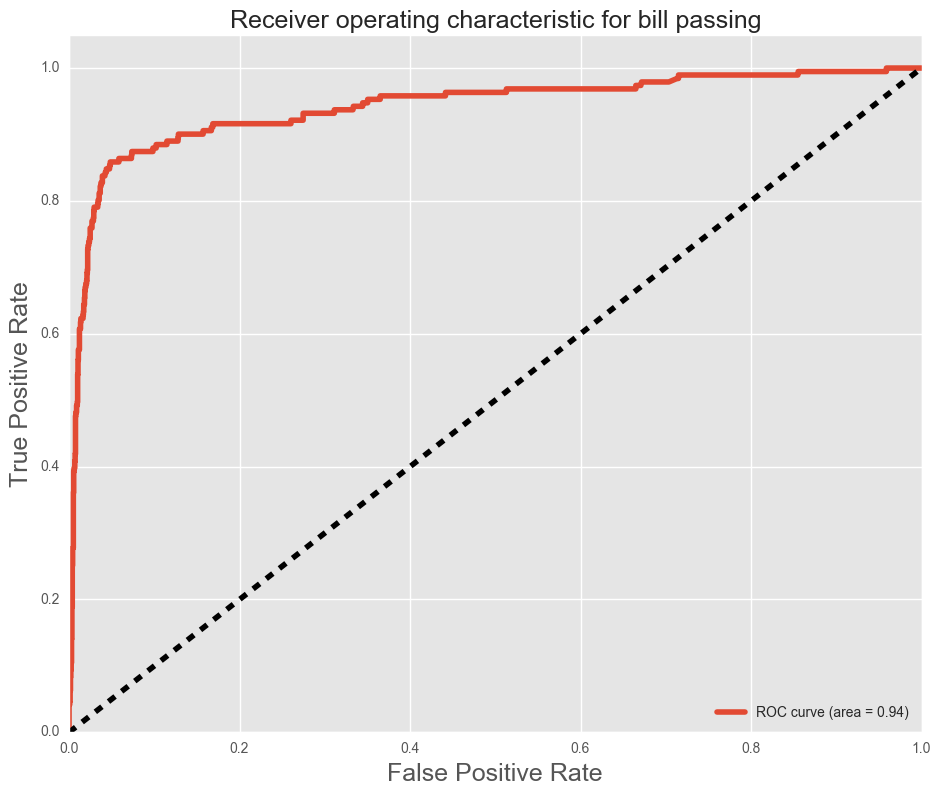

In [115]:
do_model(xgbc, X_all, y, names)

If we actually just look at the F-1 score, the lemmatized versions of just the summary, and the summary and the title perform best. However, if we look at the area under the curve, the count vectorized version just the summary still has them beat.

# LSA and LDA

OK. Let's talk about LSA and LDA.

LSA is latent semantic analysis, a technique in NLP which essentially creates a series of concepts that tie a similar pieces of texts or documents together. 

LDA is latent dirichlet allocation, a technique that topic models documents within a larger corpus by assuming that each word in the document can be tied back to one of the document's topics. 

##### From Quora:
LSA learns latent topics by performing a matrix decomposition (SVD) on the term-document matrix (aka, a form of PCA)

LDA is a generative probabilistic model, that assumes a Dirichlet prior over the latent topics.

In [116]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


In [173]:
#truncated SVD is essentially LSA. 
#the normalizer is a form of regularization
svd = TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))

#vectorize things again
vectorizer = TfidfVectorizer(max_df=0.7, max_features=10000,
                             min_df=2,
                             use_idf=True, stop_words='english')

# Build the tfidf vectorizer.
X_tfidf = vectorizer.fit_transform(df['summary'])

feat_names = vectorizer.get_feature_names()

In [174]:
X_lsa = lsa.fit_transform(X_tfidf)

In [149]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

#so 67% of variance is explained by 1000 components

Explained variance of the SVD step: 67%


In [163]:
from pylab import *

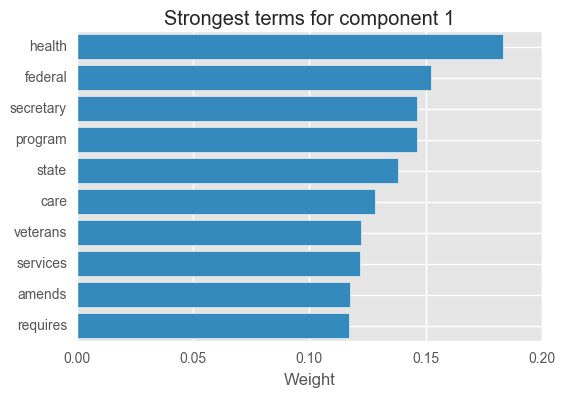

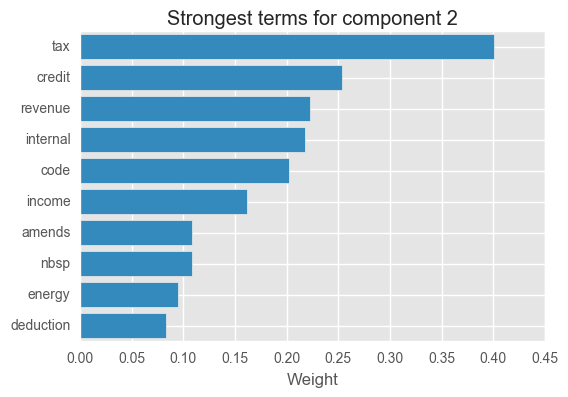

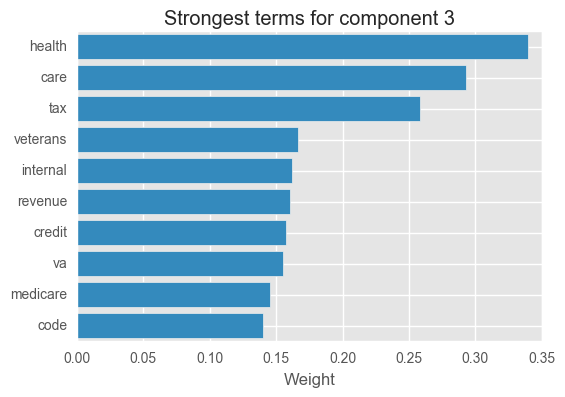

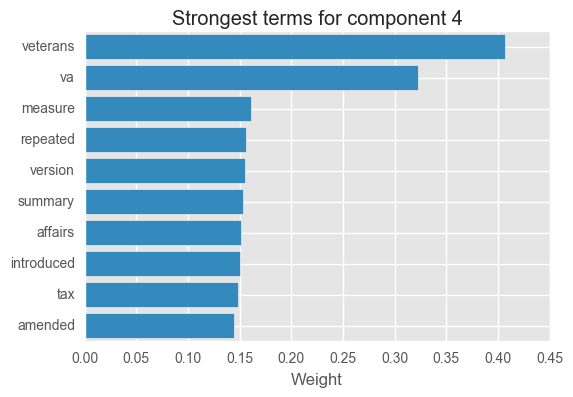

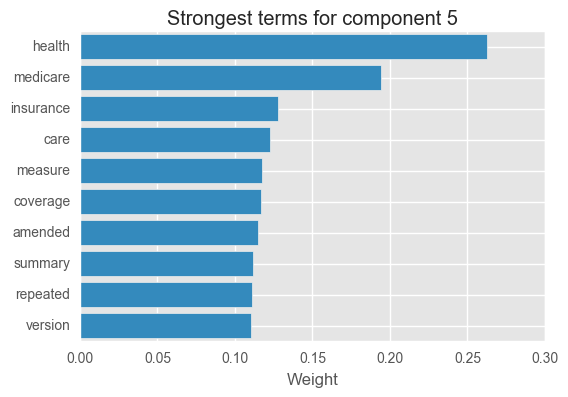

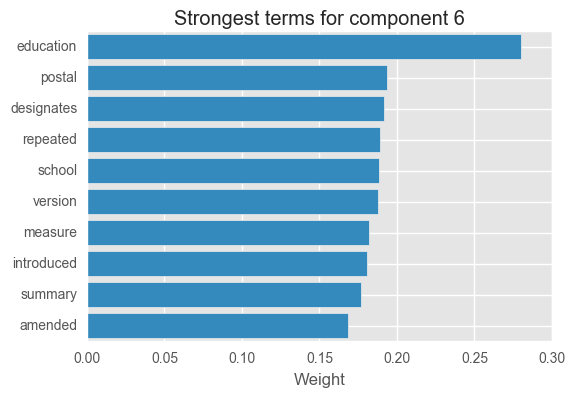

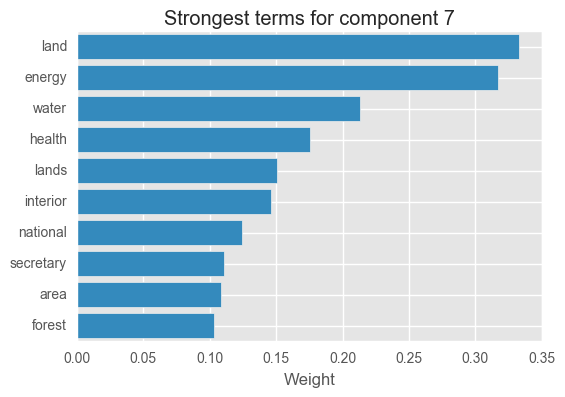

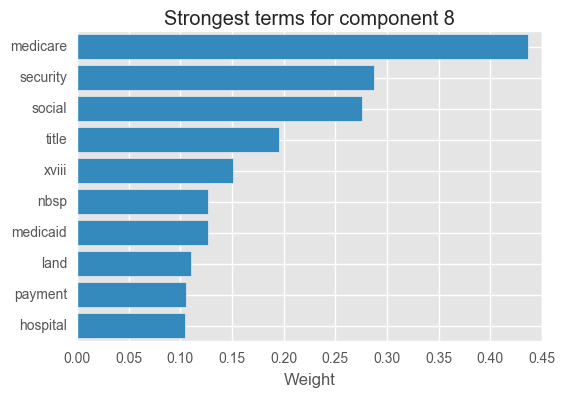

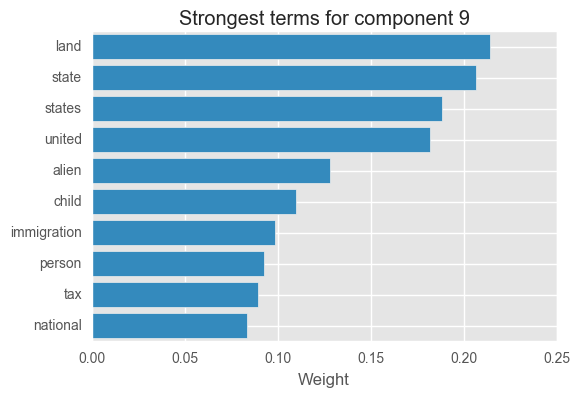

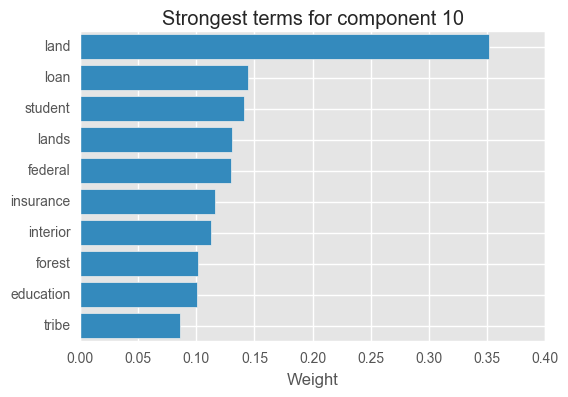

In [183]:
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = np.arange(10) + .5    # the bar centers on the y axis
    
    figure(compNum)
    barh(positions, weights, align='center')
    yticks(positions, terms)
    xlabel('Weight')
    title('Strongest terms for component %d' % (compNum+1))
    grid(True)
    show()


The next step from here would be to do some clustering, group documents by these components, and run the models again!

In [150]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [151]:
#now some LDA
lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [152]:
#let's specify what we would like to see 
n_top_words = 20
n_topics = 10
n_samples = 1000
n_features = 1000


In [153]:
#this will print out the feature names and the top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [154]:
#run a tfidf and a count vectorizer on the summary text
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(df['summary'])

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(df['summary'])


Extracting tf-idf features for NMF...
Extracting tf features for LDA...


In [155]:
#to do: learn about non-negative matrix factorization
#BUT FOR NOW: Let's do some LDA

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=1000 and n_features=1000...

Topics in LDA model:
Topic #0:
sec funds appropriations prohibits provided program used specified title fund available assistance act use provides programs permits national office activities
Topic #1:
tax act amends credit revenue income internal code nbsp year employee housing employees employer employment qualified property 2015 labor 000
Topic #2:
act states united state security dhs foreign shall person department law international government country homeland trade rights president enforcement federal
Topic #3:
act land federal national secretary interior water area lands state management transportation public project shall states forest requires dot vehicle
Topic #4:
energy requires act program federal directs agency plan development review secretary requirements report research technology environmental sec water rule doe
Topic #5:
health care services veterans va act medical secretary medicare program ser

In [157]:
print("Fitting LDA models with term frequency features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tfidf)

print("\nTopics in LDA model:")
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with term frequency features, n_samples=1000 and n_features=1000...

Topics in LDA model:
Topic #0:
act federal information sec state agency person law shall requires financial prohibits commission government amends quot employee criminal report requirements
Topic #1:
designates postal located building post facility united service memorial quot office states amended wilderness california new park national center north
Topic #2:
education program act school assistance programs student grants grant state students research educational training housing loan local higher development children
Topic #3:
house district congressional congress relief budget representatives resolution provides amendment columbia senate president fiscal debt members year joint pay committee
Topic #4:
tax revenue internal code credit income amends nbsp qualified taxpayer deduction act 000 taxable allow gross business 2015 property extend
Topic #5:
health care veterans va medicare services act med

Based on the topics generated, the next step would be to tag all the documents in the corpus with these topics and use that as a feature to determine what is more likely to pass, and what is less likely to pass.